In [1]:
import pandas as pd
import numpy as np
import polars as pl
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import gzip
import shutil
import pathlib
import os
import sqlalchemy
import sqlite3
import spacy
import re
import tqdm
from tqdm.notebook import tqdm, trange
import ipywidgets as widgets
from ipywidgets import IntProgress, HTML, VBox
from IPython.display import display
import time
import timeit

from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.nn.functional import softmax

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()

%matplotlib inline
alt.data_transformers.disable_max_rows()

#nlp = spacy.load("en_core_web_sm")
#nlp = spacy.load('/path/to/en_core_web_sm')

DataTransformerRegistry.enable('default')

In [2]:
def print_files_in_directory(directory_path):
    with os.scandir(directory_path) as entries:
        for entry in entries:
            if entry.is_file():
                print(entry.name)

def get_sentiment_score(text):
    sentiment_scores = sid_obj.polarity_scores(text)
    return sentiment_scores

In [32]:
conn = sqlite3.connect(r"C:/Users/asl4a/AirBnB_Data.db")
cursor = conn.cursor()

In [5]:
cleaned_reviews_dir_path = r"F:\Data Science\Datasets\Cleaned Reviews"
cleaned_reviews_list = []

In [8]:
print_files_in_directory(cleaned_reviews_dir_path)

Cleaned_Reviews_1.csv
Cleaned_Reviews_2.csv
Cleaned_Reviews_3.csv
Cleaned_Reviews_4.csv
Cleaned_Reviews_6.csv
Cleaned_Reviews_7.csv
Cleaned_Reviews_8.csv
Cleaned_Reviews_9.csv


In [11]:
# If this outputs a .~lock in front of a file name, it means that you have that open with something else like excel. The .lock is used to prevent the file from being changed by other applications that may have it open

with os.scandir(cleaned_reviews_dir_path) as entries:
    for entry in entries:
        if entry.is_file():
            print(entry.path)
            reviews_data = pd.read_csv(entry.path)
            cleaned_reviews_list.append(reviews_data)

reviews_df = pd.concat(cleaned_reviews_list)

F:\Data Science\Datasets\Cleaned Reviews\Cleaned_Reviews_1.csv
F:\Data Science\Datasets\Cleaned Reviews\Cleaned_Reviews_2.csv
F:\Data Science\Datasets\Cleaned Reviews\Cleaned_Reviews_3.csv
F:\Data Science\Datasets\Cleaned Reviews\Cleaned_Reviews_4.csv
F:\Data Science\Datasets\Cleaned Reviews\Cleaned_Reviews_6.csv
F:\Data Science\Datasets\Cleaned Reviews\Cleaned_Reviews_7.csv
F:\Data Science\Datasets\Cleaned Reviews\Cleaned_Reviews_8.csv
F:\Data Science\Datasets\Cleaned Reviews\Cleaned_Reviews_9.csv


In [12]:
reviews_df['comments'] = reviews_df['comments'].astype(str)
reviews_df.head()

,Unnamed: 0,SUPREME_LEADER/asl4a,Supreme_Leader,21.02.2024 14:51,file:///C:/Users/asl4a/AppData/Roaming/LibreOffice/4;,temp_index,listing_id,id,date,reviewer_id,reviewer_name,comments,cleaned_text,tokens
0,0,NaN,NaN,NaN,NaN,0.0,6422.0,1927.0,2009-04-30,14100.0,Melissa,I can't say enough about how wonderful it was ...,i cant say enough about how wonderful it was t...,"['not', 'wonderful', 'stay', 'highlight', 'sta..."
1,1,NaN,NaN,NaN,NaN,1.0,6422.0,3867.0,2009-06-11,17413.0,Raquel,Michelle and Collier's home is wonderful! They...,michelle and colliers home is wonderful they a...,"['michelle', 'collier', 'home', 'wonderful', '..."
2,2,NaN,NaN,NaN,NaN,2.0,6422.0,4159.0,2009-06-17,20253.0,Ulrike,I spent one night at Michele's home and felt j...,i spent one night at micheles home and felt ju...,"['spend', 'night', 'micheles', 'home', 'feel',..."
3,3,NaN,NaN,NaN,NaN,3.0,6422.0,5724.0,2009-07-18,22544.0,Phil,Michele and Collier are two of the loveliest p...,michele and collier are two of the loveliest p...,"['michele', 'collier', 'lovely', 'people', 'pl..."
4,4,NaN,NaN,NaN,NaN,4.0,6422.0,11891.0,2009-09-29,33409.0,Claire,We had the most lovely time staying with Miche...,we had the most lovely time staying with miche...,"['lovely', 'time', 'stay', 'michele', 'colly',..."


In [13]:
reviews_df = reviews_df.drop(['21.02.2024 14:51','file:///C:/Users/asl4a/AppData/Roaming/LibreOffice/4;','SUPREME_LEADER/asl4a'],axis=1)
reviews_df.head()

,Unnamed: 0,Supreme_Leader,temp_index,listing_id,id,date,reviewer_id,reviewer_name,comments,cleaned_text,tokens
0,0,NaN,0.0,6422.0,1927.0,2009-04-30,14100.0,Melissa,I can't say enough about how wonderful it was ...,i cant say enough about how wonderful it was t...,"['not', 'wonderful', 'stay', 'highlight', 'sta..."
1,1,NaN,1.0,6422.0,3867.0,2009-06-11,17413.0,Raquel,Michelle and Collier's home is wonderful! They...,michelle and colliers home is wonderful they a...,"['michelle', 'collier', 'home', 'wonderful', '..."
2,2,NaN,2.0,6422.0,4159.0,2009-06-17,20253.0,Ulrike,I spent one night at Michele's home and felt j...,i spent one night at micheles home and felt ju...,"['spend', 'night', 'micheles', 'home', 'feel',..."
3,3,NaN,3.0,6422.0,5724.0,2009-07-18,22544.0,Phil,Michele and Collier are two of the loveliest p...,michele and collier are two of the loveliest p...,"['michele', 'collier', 'lovely', 'people', 'pl..."
4,4,NaN,4.0,6422.0,11891.0,2009-09-29,33409.0,Claire,We had the most lovely time staying with Miche...,we had the most lovely time staying with miche...,"['lovely', 'time', 'stay', 'michele', 'colly',..."


In [14]:
reviews_df = reviews_df.drop(['Supreme_Leader'],axis=1)

In [15]:
reviews_df.dtypes

Unnamed: 0        object
temp_index       float64
listing_id       float64
id               float64
date              object
reviewer_id      float64
reviewer_name     object
comments          object
cleaned_text      object
tokens            object
dtype: object

In [16]:
torch.cuda.is_available()

True

In [17]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

#a = torch.zeros(4,3)
#a = a.to(device)

In [19]:
reviews_df['cleaned_text'] = reviews_df['cleaned_text'].astype(str)

In [24]:
start_time = time.time()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
seed = 966
torch.manual_seed(seed)



def get_sentiment_score(text):
    inputs = tokenizer(text, return_tensors='pt',truncation=True,padding=True)
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)

        # Apply softmax to get probabilities
        probs = softmax(outputs.logits, dim=-1)

        # The second index corresponds to the positive class in sentiment analysis
        positive_probability = probs[0,1].item()

        return positive_probability

reviews_df['bert_sentiments'] = reviews_df['cleaned_text'][50000:100000].apply(get_sentiment_score)

#print(device)
end_time = time.time()
print(end_time - start_time)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


348.75683856010437


In [21]:
reviews_df2 = pd.DataFrame(reviews_df[['Unnamed: 0', 'bert_sentiments']])

In [22]:
reviews_df2.to_csv('reviews_df2_processed_2.csv')

In [23]:
reviews_df2

,Unnamed: 0,bert_sentiments
0,0,0.585403
1,1,0.570345
2,2,0.576360
3,3,0.576952
4,4,0.589572
...,...,...
1668040,9668040,NaN
1668041,9668041,NaN
1668042,9668042,NaN
1668043,9668043,NaN


In [11]:
# device = torch.device('cuda')
# print(torch.cuda.is_available())

In [12]:
#torch.cuda.current_device()

In [13]:
# cuda_id = torch.cuda.current_device()
# torch.cuda.get_device_name(cuda_id)

In [14]:
# torch.version.cuda

In [ ]:
#reviews_df.to_csv('reviews_df_processed_1.csv')

In [10]:
reviews_df['bert_sentiments']

0          0.595194
1          0.571474
2          0.556534
3          0.574392
4          0.587863
             ...   
1668040         NaN
1668041         NaN
1668042         NaN
1668043         NaN
1668044         NaN
Name: bert_sentiments, Length: 10668047, dtype: float64

In [11]:
len(reviews_df['comments'])

10668047

In [35]:
new_reviews_df = pd.read_sql("""
SELECT l.id, l.review_scores_rating, r.id, r.comments
FROM listings l
JOIN reviews r ON l.id = r.id
LIMIT 1000;""",con=conn)

In [36]:
new_reviews_df

,id,review_scores_rating,id,comments
0,632636,4.97,632636,"I loved staying at Houston's and was very, ver..."
1,11320018,4.92,11320018,"Ryan was a great host, easy to contact, quick ..."
2,12038428,4.95,12038428,We had a wonderful stay at Monte Cristo. Jay h...
3,19606463,4.93,19606463,habitacion comoda y limpia \r<br/>
4,23488754,4.81,23488754,Excelente estadía en Providence. El barrio es ...
...,...,...,...,...
838,53052940,4.00,53052940,Had a perfect stay at Asi's. What a super star...
839,53309319,5.00,53309319,Carolyn is a warm open considerate and flexibl...
840,53595701,3.00,53595701,I would like to challenge the claim and call t...
841,54295367,NaN,54295367,Lori immediately made me feel welcome in her b...


In [37]:
new_reviews_df['normalized_ratings'] = new_reviews_df['review_scores_rating'] / new_reviews_df['review_scores_rating'].abs().max()

In [38]:
new_reviews_df

,id,review_scores_rating,id,comments,normalized_ratings
0,632636,4.97,632636,"I loved staying at Houston's and was very, ver...",0.994
1,11320018,4.92,11320018,"Ryan was a great host, easy to contact, quick ...",0.984
2,12038428,4.95,12038428,We had a wonderful stay at Monte Cristo. Jay h...,0.990
3,19606463,4.93,19606463,habitacion comoda y limpia \r<br/>,0.986
4,23488754,4.81,23488754,Excelente estadía en Providence. El barrio es ...,0.962
...,...,...,...,...,...
838,53052940,4.00,53052940,Had a perfect stay at Asi's. What a super star...,0.800
839,53309319,5.00,53309319,Carolyn is a warm open considerate and flexibl...,1.000
840,53595701,3.00,53595701,I would like to challenge the claim and call t...,0.600
841,54295367,NaN,54295367,Lori immediately made me feel welcome in her b...,NaN


<Axes: xlabel='normalized_ratings', ylabel='Count'>

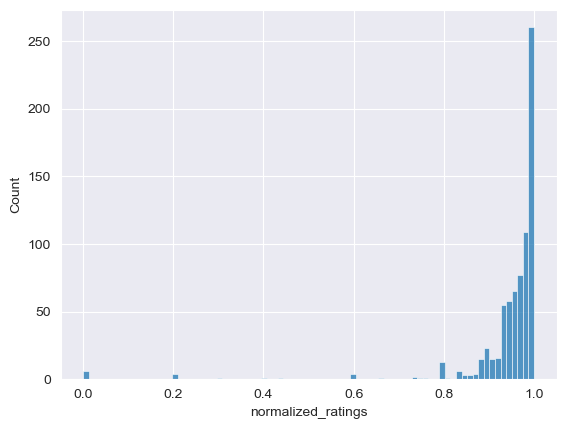

In [39]:
sns.histplot(new_reviews_df['normalized_ratings'])

<Axes: xlabel='review_scores_rating', ylabel='Count'>

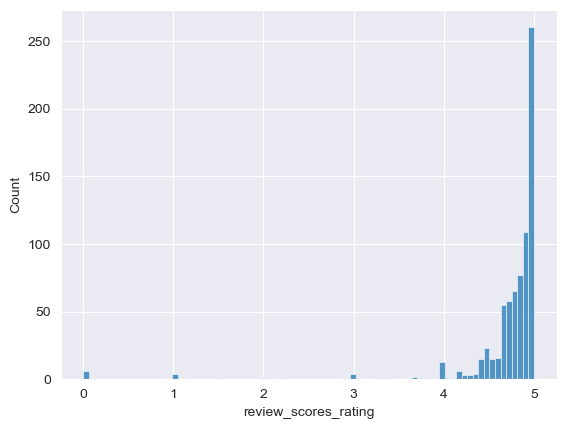

In [40]:
sns.histplot(new_reviews_df['review_scores_rating'])

In [31]:
sql = """
SELECT *
FROM AirBnB_Data.listings
LIMIT 100;
"""

new_reviews_df = pd.read_sql(sql,con=conn)

DatabaseError: Execution failed on sql '
SELECT *
FROM AirBnB_Data.listings
LIMIT 100;
': no such table: AirBnB_Data.listings